In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from sklearn.metrics import f1_score, classification_report, confusion_matrix 
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline


2138


In [ ]:
import pathlib

train_dir = pathlib.Path("img_kagl_train")

In [16]:
batch_size = 32
image_size = (180, 180)

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=image_size,
  batch_size=batch_size)


Found 2138 files belonging to 4 classes.
Using 1711 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainn_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=image_size,
  batch_size=batch_size)


Found 2138 files belonging to 4 classes.
Using 427 files for validation.


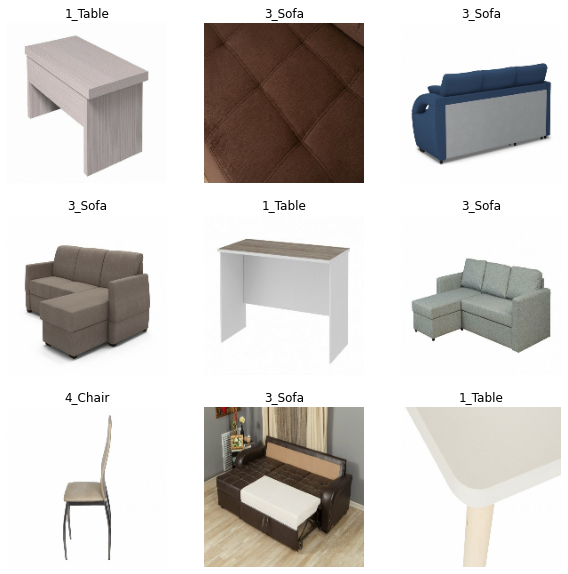

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [38]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [39]:
IMG_SHAPE = (180, 180, 3)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [41]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [42]:
base_model.trainable = False

In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [44]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [45]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
epochs = 15
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)


Epoch 1/15
54/54 [==============================] - 10s 135ms/step - loss: 0.9686 - accuracy: 0.6588 - val_loss: 0.3466 - val_accuracy: 0.8899
Epoch 2/15
54/54 [==============================] - 5s 102ms/step - loss: 0.3010 - accuracy: 0.9128 - val_loss: 0.3410 - val_accuracy: 0.8782
Epoch 3/15
54/54 [==============================] - 6s 103ms/step - loss: 0.2441 - accuracy: 0.9138 - val_loss: 0.2786 - val_accuracy: 0.9016
Epoch 4/15
54/54 [==============================] - 6s 103ms/step - loss: 0.2693 - accuracy: 0.9010 - val_loss: 0.2951 - val_accuracy: 0.9110
Epoch 5/15
54/54 [==============================] - 5s 102ms/step - loss: 0.2043 - accuracy: 0.9230 - val_loss: 0.2535 - val_accuracy: 0.9133
Epoch 6/15
54/54 [==============================] - 5s 101ms/step - loss: 0.1761 - accuracy: 0.9381 - val_loss: 0.2441 - val_accuracy: 0.9110
Epoch 7/15
54/54 [==============================] - 5s 101ms/step - loss: 0.1789 - accuracy: 0.9343 - val_loss: 0.2865 - val_accuracy: 0.9133
Epoch

Text(0.5, 0, 'epoch')

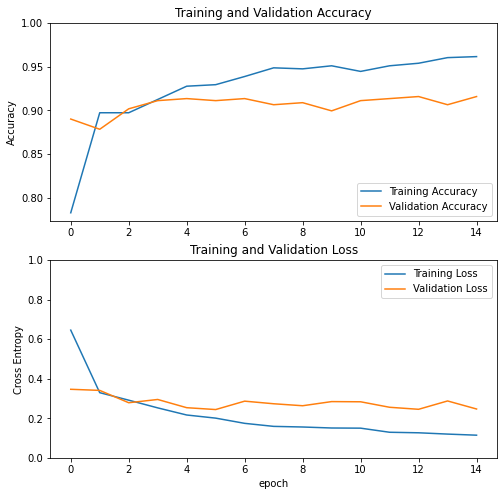

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


In [51]:
from sklearn.metrics import classification_report

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds).argmax(axis=-1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       135
           1       0.73      0.59      0.65        27
           2       0.94      0.93      0.94       195
           3       0.93      0.89      0.91        70

    accuracy                           0.92       427
   macro avg       0.87      0.85      0.86       427
weighted avg       0.91      0.92      0.91       427



In [58]:
print(confusion_matrix(y_true, y_pred))

[[132   0   0   3]
 [  1  16   9   1]
 [  7   6 181   1]
 [  6   0   2  62]]


In [59]:
X = np.array([x.flatten() for x in np.concatenate([x for x, y in train_ds], axis=0)])

In [67]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

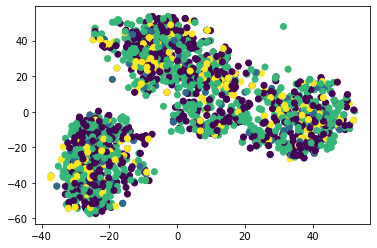

In [71]:
y_true_on_train = np.concatenate([y for x, y in train_ds], axis=0)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true_on_train)

In [ ]:
test_dir = pathlib.Path("img_kagl_test")

results = dict()
for path in list(test_dir.glob('*.jpg')):
   img = keras.preprocessing.image.load_img(path, target_size=image_size)
   img = keras.preprocessing.image.img_to_array(img)
   img = np.expand_dims(img, axis=0)
   res = model.predict(img).argmax(axis=-1)[0] + 1
   results[path.name] = res

In [ ]:
df = pd.DataFrame.from_dict({"Image": list(results.keys()), "Type": list(results.values())})
df.to_csv("results.csv", index=None)